In [ ]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="jEpWSuaWS6lKeyk8uJXY")
project = rf.workspace("plastic-b0ep9").project("plastic-detection-2kkwi")
version = project.version(5)
dataset = version.download("paligemma")

In [ ]:
# Redundant installation removed after consolidating in the cell above.

Analyzing images: 100%|██████████| 200/200 [00:00<00:00, 3637.78it/s]



                         PALIGEMMA DATASET ANALYSIS REPORT

📊 DATASET OVERVIEW
   Total Images: 10,945
   Total Annotations: 11,387
   Number of Classes: 1
   Train/Test Ratio: 10.11
   ✅ No data leakage detected

🎯 CLASS STATISTICS
   plastic: 11387 annotations (100.0%) in 10482 images

📐 SPATIAL DISTRIBUTION
   Small objects: 292 (2.8%)
   Medium objects: 5971 (57.8%)
   Large objects: 4061 (39.3%)



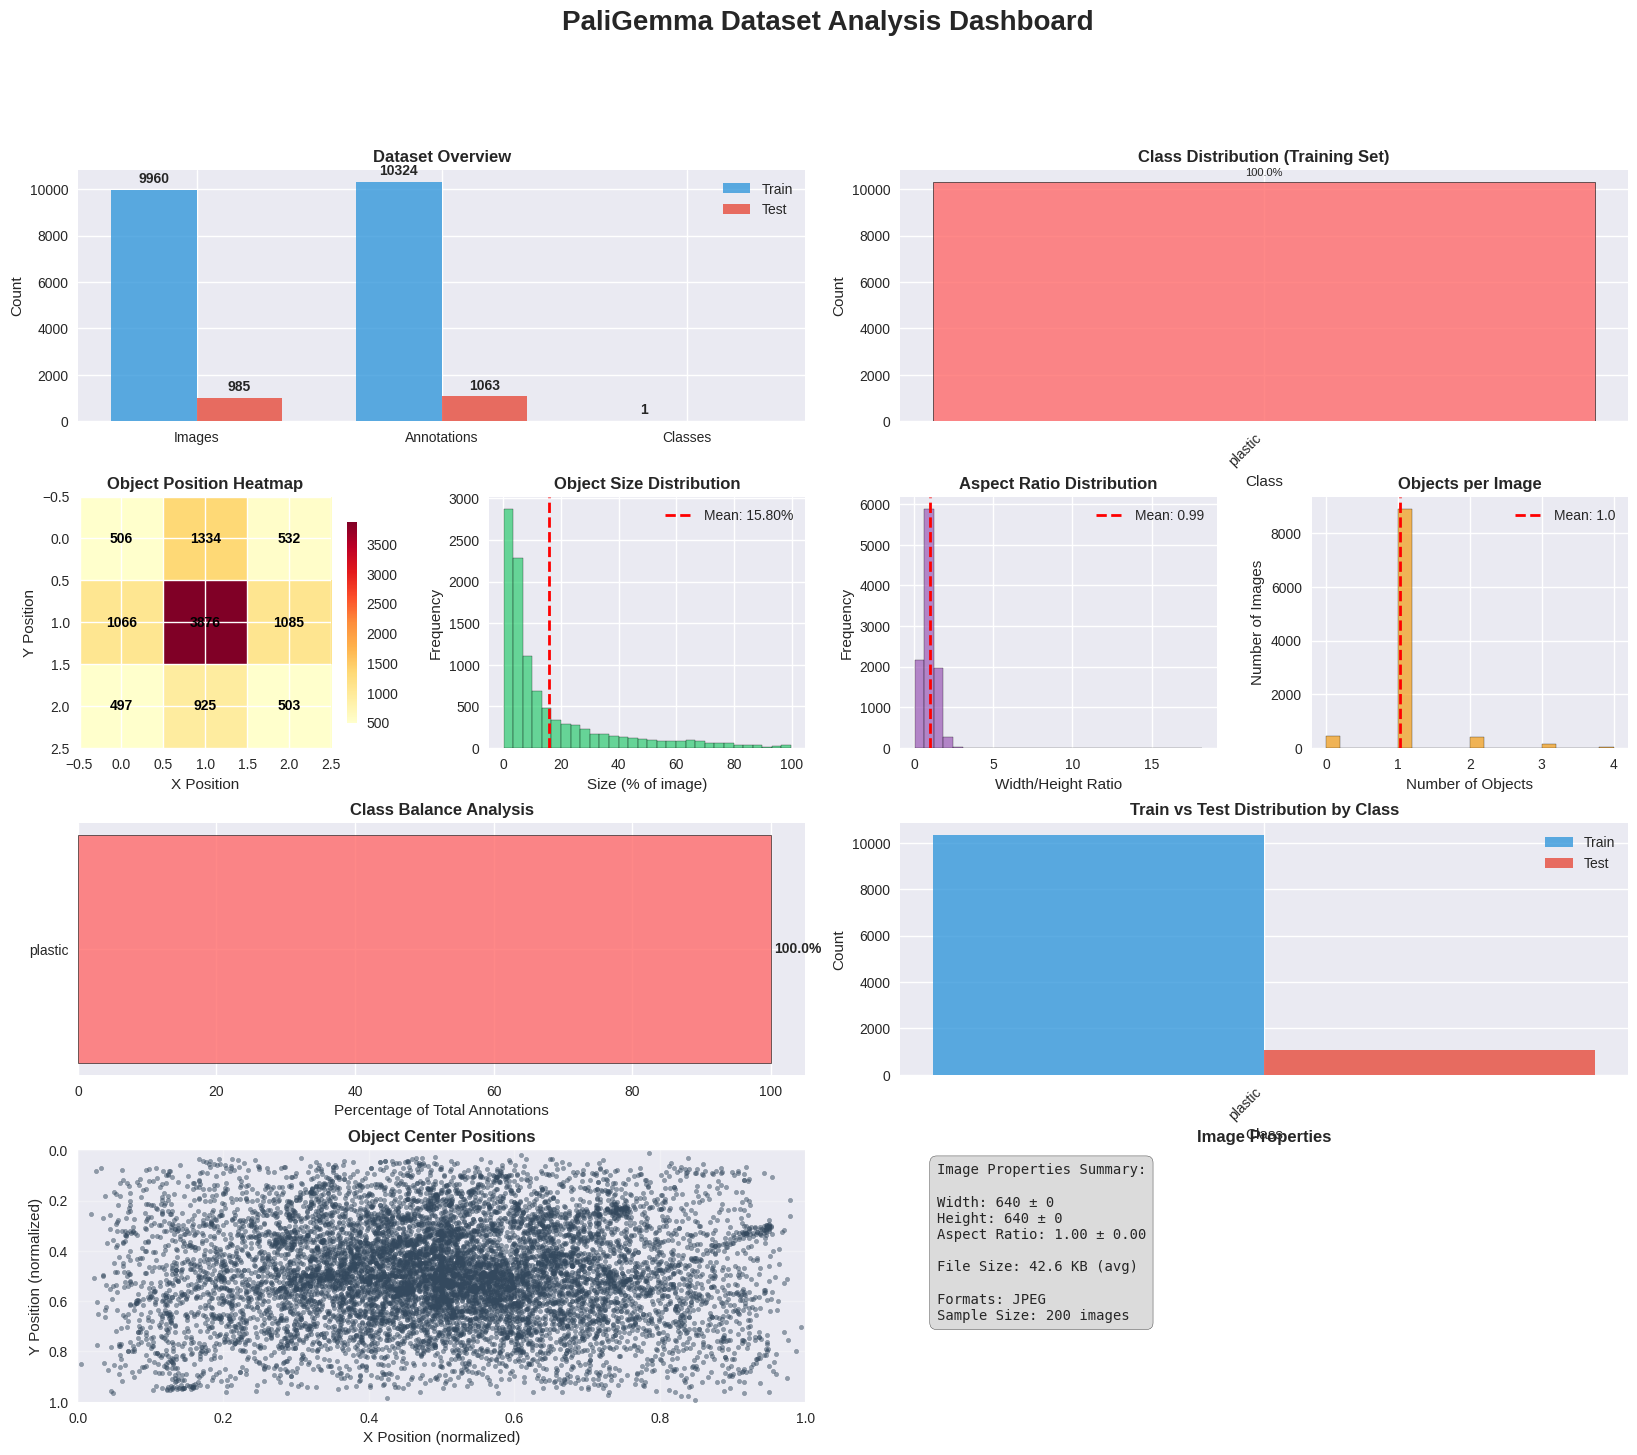

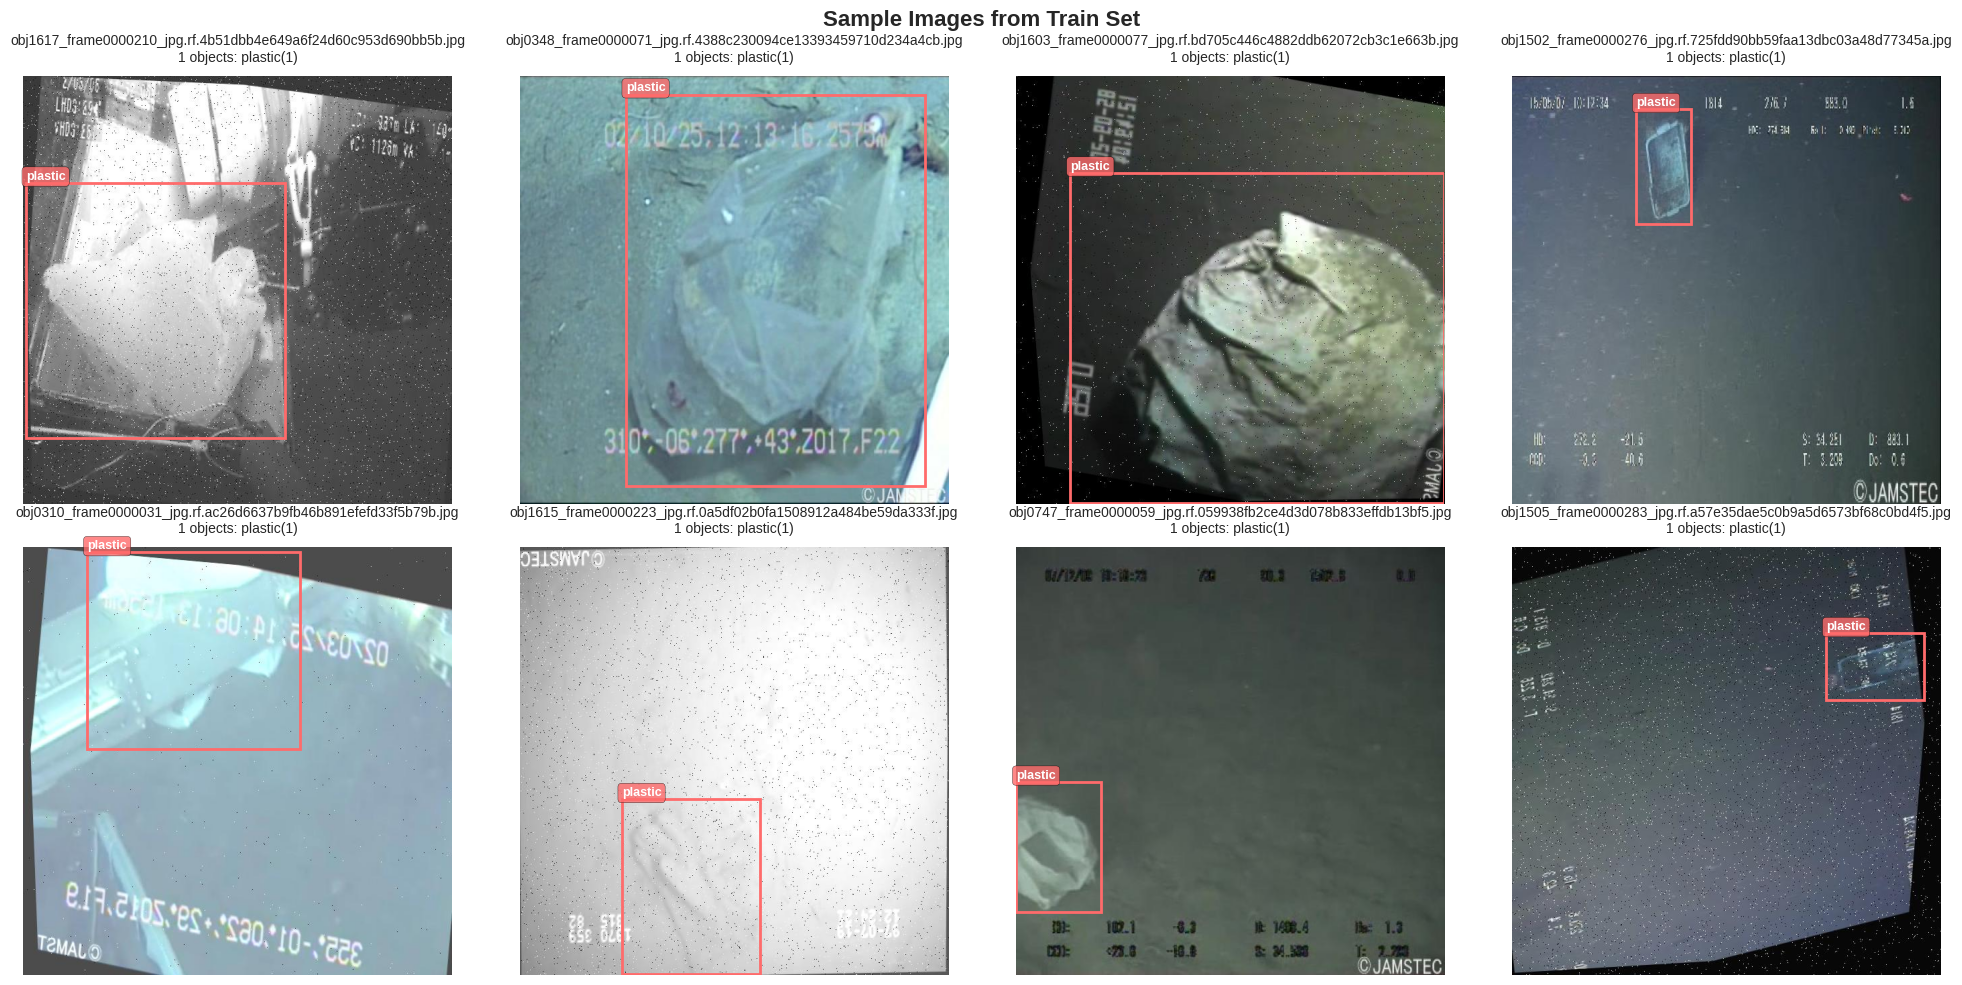


✅ Analysis complete! Check the visualizations and saved report.


In [ ]:
import json
import os
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from pathlib import Path
import re
from PIL import Image, ImageDraw, ImageFont
import cv2
import random
from typing import List, Dict, Tuple, Optional, Union
import warnings
import logging
from datetime import datetime
from dataclasses import dataclass
from tqdm import tqdm

# Configure plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

@dataclass
class BoundingBox:
    """Data class for bounding box with validation"""
    x1: float
    y1: float
    x2: float
    y2: float
    class_name: str
    confidence: Optional[float] = None

    def __post_init__(self):
        """Validate bounding box coordinates"""
        if self.x1 >= self.x2 or self.y1 >= self.y2:
            raise ValueError(f"Invalid bbox coordinates: ({self.x1}, {self.y1}, {self.x2}, {self.y2})")

    @property
    def width(self) -> float:
        return self.x2 - self.x1

    @property
    def height(self) -> float:
        return self.y2 - self.y1

    @property
    def area(self) -> float:
        return self.width * self.height

    @property
    def aspect_ratio(self) -> float:
        return self.width / self.height if self.height > 0 else 0

    @property
    def center(self) -> Tuple[float, float]:
        return ((self.x1 + self.x2) / 2, (self.y1 + self.y2) / 2)

class EnhancedPaliGemmaAnalyzer:
    """Enhanced analyzer for PaliGemma datasets with comprehensive analysis and visualization"""

    def __init__(self, train_path: str, test_path: str, dataset_root: str,
                 cache_dir: str = ".cache", log_level: str = "INFO"):
        self.train_path = Path(train_path)
        self.test_path = Path(test_path)
        self.dataset_root = Path(dataset_root)
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)

        # Setup logging
        logging.basicConfig(level=getattr(logging, log_level))
        self.logger = logging.getLogger(__name__)

        # Data storage
        self.train_data = []
        self.test_data = []
        self.image_cache = {}

        # Analysis results
        self.stats = {}
        self.class_info = {}

        # Visualization settings
        self.color_palette = [
            '#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7',
            '#DDA0DD', '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9',
            '#F8C471', '#82E0AA', '#F1948A', '#85929E', '#D2B4DE'
        ]
        self.class_colors = {}

    def _setup_class_colors(self):
        """Assign unique colors to each class"""
        all_classes = set()
        for item in self.train_data + self.test_data:
            bboxes = self._parse_bbox_from_suffix(item['suffix'])
            for bbox in bboxes:
                all_classes.add(bbox.class_name)

        for idx, class_name in enumerate(sorted(all_classes)):
            self.class_colors[class_name] = self.color_palette[idx % len(self.color_palette)]

        self.logger.info(f"Assigned colors to {len(all_classes)} classes")

    def load_data(self) -> None:
        """Load and validate annotation files"""
        self.logger.info("Loading annotation files...")

        # Load training data
        if not self.train_path.exists():
            raise FileNotFoundError(f"Training file not found: {self.train_path}")

        with open(self.train_path, 'r', encoding='utf-8') as f:
            self.train_data = [json.loads(line) for line in f]

        # Load test data
        if not self.test_path.exists():
            raise FileNotFoundError(f"Test file not found: {self.test_path}")

        with open(self.test_path, 'r', encoding='utf-8') as f:
            self.test_data = [json.loads(line) for line in f]

        self.logger.info(f"Loaded {len(self.train_data)} train and {len(self.test_data)} test annotations")

        # Setup colors after loading data
        self._setup_class_colors()

        # Validate data
        self._validate_data()

    def _validate_data(self) -> None:
        """Validate loaded data for common issues"""
        self.logger.info("Validating dataset...")

        issues = []

        # Check for missing images
        missing_images = 0
        for split_name, data in [("train", self.train_data), ("test", self.test_data)]:
            for item in data:
                img_path = self.dataset_root / item['image']
                if not img_path.exists():
                    missing_images += 1

        if missing_images > 0:
            issues.append(f"Missing {missing_images} image files")

        # Check for duplicate images across splits
        train_images = {item['image'] for item in self.train_data}
        test_images = {item['image'] for item in self.test_data}
        overlap = train_images.intersection(test_images)

        if overlap:
            issues.append(f"Data leakage: {len(overlap)} images in both train and test")

        # Report issues
        if issues:
            for issue in issues:
                self.logger.warning(issue)
        else:
            self.logger.info("✓ Data validation passed")

    def _parse_bbox_from_suffix(self, suffix: str) -> List[BoundingBox]:
        """Parse bounding boxes from PaliGemma suffix format with error handling"""
        pattern = r'<loc(\d{4})><loc(\d{4})><loc(\d{4})><loc(\d{4})>\s*([^<\s]+)'
        matches = re.findall(pattern, suffix)

        bboxes = []
        for match in matches:
            try:
                y1, x1, y2, x2, class_name = match
                # Convert from normalized 1024 coordinates to relative coordinates
                bbox = BoundingBox(
                    x1=int(x1) / 1024,
                    y1=int(y1) / 1024,
                    x2=int(x2) / 1024,
                    y2=int(y2) / 1024,
                    class_name=class_name.strip()
                )
                bboxes.append(bbox)
            except (ValueError, ZeroDivisionError) as e:
                self.logger.warning(f"Invalid bbox in suffix: {match}, error: {e}")

        return bboxes

    def analyze_dataset_overview(self) -> Dict:
        """Comprehensive dataset overview analysis"""
        self.logger.info("Analyzing dataset overview...")

        # Basic statistics
        train_images = {item['image'] for item in self.train_data}
        test_images = {item['image'] for item in self.test_data}
        total_images = train_images.union(test_images)
        overlap = train_images.intersection(test_images)

        # Count annotations
        train_annotations = sum(len(self._parse_bbox_from_suffix(item['suffix']))
                              for item in self.train_data)
        test_annotations = sum(len(self._parse_bbox_from_suffix(item['suffix']))
                             for item in self.test_data)

        # Class analysis
        all_classes = set()
        for item in self.train_data + self.test_data:
            bboxes = self._parse_bbox_from_suffix(item['suffix'])
            for bbox in bboxes:
                all_classes.add(bbox.class_name)

        overview = {
            'total_images': len(total_images),
            'train_images': len(train_images),
            'test_images': len(test_images),
            'image_overlap': len(overlap),
            'total_annotations': train_annotations + test_annotations,
            'train_annotations': train_annotations,
            'test_annotations': test_annotations,
            'num_classes': len(all_classes),
            'classes': sorted(list(all_classes)),
            'train_test_ratio': len(train_images) / len(test_images) if test_images else float('inf')
        }

        self.stats['overview'] = overview
        return overview

    def analyze_class_distribution(self) -> Dict:
        """Detailed class distribution analysis"""
        self.logger.info("Analyzing class distribution...")

        train_classes = Counter()
        test_classes = Counter()
        class_stats = defaultdict(lambda: {
            'train_count': 0, 'test_count': 0, 'total_count': 0,
            'train_images': set(), 'test_images': set(),
            'areas': [], 'aspect_ratios': []
        })

        # Analyze training data
        for item in self.train_data:
            bboxes = self._parse_bbox_from_suffix(item['suffix'])
            for bbox in bboxes:
                train_classes[bbox.class_name] += 1
                class_stats[bbox.class_name]['train_count'] += 1
                class_stats[bbox.class_name]['train_images'].add(item['image'])
                class_stats[bbox.class_name]['areas'].append(bbox.area)
                class_stats[bbox.class_name]['aspect_ratios'].append(bbox.aspect_ratio)

        # Analyze test data
        for item in self.test_data:
            bboxes = self._parse_bbox_from_suffix(item['suffix'])
            for bbox in bboxes:
                test_classes[bbox.class_name] += 1
                class_stats[bbox.class_name]['test_count'] += 1
                class_stats[bbox.class_name]['test_images'].add(item['image'])
                class_stats[bbox.class_name]['areas'].append(bbox.area)
                class_stats[bbox.class_name]['aspect_ratios'].append(bbox.aspect_ratio)

        # Calculate final statistics
        for class_name in class_stats:
            stats = class_stats[class_name]
            stats['total_count'] = stats['train_count'] + stats['test_count']
            stats['train_image_count'] = len(stats['train_images'])
            stats['test_image_count'] = len(stats['test_images'])
            stats['total_image_count'] = len(stats['train_images'].union(stats['test_images']))

            if stats['areas']:
                stats['avg_area'] = np.mean(stats['areas'])
                stats['std_area'] = np.std(stats['areas'])
                stats['avg_aspect_ratio'] = np.mean(stats['aspect_ratios'])

            # Remove sets to make serializable
            del stats['train_images'], stats['test_images']

        distribution = {
            'train_classes': dict(train_classes),
            'test_classes': dict(test_classes),
            'class_details': dict(class_stats)
        }

        self.stats['class_distribution'] = distribution
        self.class_info = dict(class_stats)
        return distribution

    def analyze_spatial_distribution(self) -> Dict:
        """Analyze spatial distribution of objects"""
        self.logger.info("Analyzing spatial distribution...")

        # Grid analysis (divide image into 3x3 grid)
        grid_counts = np.zeros((3, 3))
        center_positions = []
        size_categories = {'small': 0, 'medium': 0, 'large': 0}

        for item in self.train_data:
            bboxes = self._parse_bbox_from_suffix(item['suffix'])
            for bbox in bboxes:
                # Grid position
                grid_x = min(int(bbox.center[0] * 3), 2)
                grid_y = min(int(bbox.center[1] * 3), 2)
                grid_counts[grid_y, grid_x] += 1

                # Center positions
                center_positions.append(bbox.center)

                # Size categorization
                area = bbox.area
                if area < 0.01:  # Less than 1% of image
                    size_categories['small'] += 1
                elif area < 0.1:  # Less than 10% of image
                    size_categories['medium'] += 1
                else:
                    size_categories['large'] += 1

        spatial = {
            'grid_distribution': grid_counts.tolist(),
            'center_positions': center_positions,
            'size_categories': size_categories
        }

        self.stats['spatial'] = spatial
        return spatial

    def analyze_image_properties(self, sample_size: int = 200) -> Dict:
        """Analyze image properties with sampling for efficiency"""
        self.logger.info(f"Analyzing image properties (sample size: {sample_size})...")

        # Sample images for analysis
        all_images = list({item['image'] for item in self.train_data + self.test_data})
        sample_images = random.sample(all_images, min(sample_size, len(all_images)))

        dimensions = []
        formats = Counter()
        file_sizes = []

        for img_name in tqdm(sample_images, desc="Analyzing images"):
            img_path = self.dataset_root / img_name
            if img_path.exists():
                try:
                    with Image.open(img_path) as img:
                        dimensions.append((img.width, img.height))
                        formats[img.format] += 1
                        file_sizes.append(img_path.stat().st_size / 1024)  # KB
                except Exception as e:
                    self.logger.warning(f"Error reading {img_name}: {e}")

        if dimensions:
            widths, heights = zip(*dimensions)
            aspect_ratios = [w/h for w, h in dimensions]

            properties = {
                'sample_size': len(dimensions),
                'width_stats': {
                    'min': min(widths), 'max': max(widths),
                    'mean': np.mean(widths), 'std': np.std(widths)
                },
                'height_stats': {
                    'min': min(heights), 'max': max(heights),
                    'mean': np.mean(heights), 'std': np.std(heights)
                },
                'aspect_ratio_stats': {
                    'min': min(aspect_ratios), 'max': max(aspect_ratios),
                    'mean': np.mean(aspect_ratios), 'std': np.std(aspect_ratios)
                },
                'formats': dict(formats),
                'file_size_stats': {
                    'min_kb': min(file_sizes) if file_sizes else 0,
                    'max_kb': max(file_sizes) if file_sizes else 0,
                    'mean_kb': np.mean(file_sizes) if file_sizes else 0
                }
            }
        else:
            properties = {'error': 'No valid images found'}

        self.stats['image_properties'] = properties
        return properties

    def create_comprehensive_visualizations(self) -> None:
        """Create comprehensive visualization dashboard"""
        self.logger.info("Creating comprehensive visualizations...")

        # Create large figure with subplots
        fig = plt.figure(figsize=(20, 16))
        gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

        # 1. Dataset Overview (2x2)
        ax1 = fig.add_subplot(gs[0, :2])
        self._plot_dataset_overview(ax1)

        # 2. Class Distribution (2x2)
        ax2 = fig.add_subplot(gs[0, 2:])
        self._plot_class_distribution(ax2)

        # 3. Spatial Distribution Heatmap
        ax3 = fig.add_subplot(gs[1, 0])
        self._plot_spatial_heatmap(ax3)

        # 4. Object Size Distribution
        ax4 = fig.add_subplot(gs[1, 1])
        self._plot_size_distribution(ax4)

        # 5. Aspect Ratio Distribution
        ax5 = fig.add_subplot(gs[1, 2])
        self._plot_aspect_ratio_distribution(ax5)

        # 6. Objects per Image
        ax6 = fig.add_subplot(gs[1, 3])
        self._plot_objects_per_image(ax6)

        # 7. Class Balance Analysis
        ax7 = fig.add_subplot(gs[2, :2])
        self._plot_class_balance(ax7)

        # 8. Train vs Test Comparison
        ax8 = fig.add_subplot(gs[2, 2:])
        self._plot_train_test_comparison(ax8)

        # 9. Center Position Scatter
        ax9 = fig.add_subplot(gs[3, :2])
        self._plot_center_positions(ax9)

        # 10. Image Properties
        ax10 = fig.add_subplot(gs[3, 2:])
        self._plot_image_properties(ax10)

        plt.suptitle('PaliGemma Dataset Analysis Dashboard', fontsize=20, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def _plot_dataset_overview(self, ax):
        """Plot dataset overview statistics"""
        overview = self.stats['overview']

        categories = ['Images', 'Annotations', 'Classes']
        train_values = [overview['train_images'], overview['train_annotations'], overview['num_classes']]
        test_values = [overview['test_images'], overview['test_annotations'], 0]  # Classes don't split

        x = np.arange(len(categories))
        width = 0.35

        bars1 = ax.bar(x - width/2, train_values, width, label='Train', color='#3498db', alpha=0.8)
        bars2 = ax.bar(x + width/2, test_values, width, label='Test', color='#e74c3c', alpha=0.8)

        ax.set_title('Dataset Overview', fontweight='bold')
        ax.set_ylabel('Count')
        ax.set_xticks(x)
        ax.set_xticklabels(categories)
        ax.legend()

        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.annotate(f'{int(height)}',
                               xy=(bar.get_x() + bar.get_width() / 2, height),
                               xytext=(0, 3), textcoords="offset points",
                               ha='center', va='bottom', fontweight='bold')

    def _plot_class_distribution(self, ax):
        """Plot class distribution"""
        dist = self.stats['class_distribution']

        classes = list(dist['train_classes'].keys())
        train_counts = [dist['train_classes'][c] for c in classes]

        colors = [self.class_colors[c] for c in classes]
        bars = ax.bar(classes, train_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

        ax.set_title('Class Distribution (Training Set)', fontweight='bold')
        ax.set_xlabel('Class')
        ax.set_ylabel('Count')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        # Add percentage labels
        total = sum(train_counts)
        for bar, count in zip(bars, train_counts):
            percentage = count / total * 100
            ax.annotate(f'{percentage:.1f}%',
                       xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)

    def _plot_spatial_heatmap(self, ax):
        """Plot spatial distribution heatmap"""
        grid = np.array(self.stats['spatial']['grid_distribution'])

        im = ax.imshow(grid, cmap='YlOrRd', interpolation='nearest')
        ax.set_title('Object Position Heatmap', fontweight='bold')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')

        # Add text annotations
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, f'{int(grid[i, j])}',
                              ha="center", va="center", color="black", fontweight='bold')

        plt.colorbar(im, ax=ax, shrink=0.8)

    def _plot_size_distribution(self, ax):
        """Plot object size distribution"""
        areas = []
        for item in self.train_data:
            bboxes = self._parse_bbox_from_suffix(item['suffix'])
            areas.extend([bbox.area * 100 for bbox in bboxes])  # Convert to percentage

        ax.hist(areas, bins=30, alpha=0.7, color='#2ecc71', edgecolor='black')
        ax.set_title('Object Size Distribution', fontweight='bold')
        ax.set_xlabel('Size (% of image)')
        ax.set_ylabel('Frequency')
        ax.axvline(np.mean(areas), color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {np.mean(areas):.2f}%')
        ax.legend()

    def _plot_aspect_ratio_distribution(self, ax):
        """Plot aspect ratio distribution"""
        ratios = []
        for item in self.train_data:
            bboxes = self._parse_bbox_from_suffix(item['suffix'])
            ratios.extend([bbox.aspect_ratio for bbox in bboxes])

        ax.hist(ratios, bins=30, alpha=0.7, color='#9b59b6', edgecolor='black')
        ax.set_title('Aspect Ratio Distribution', fontweight='bold')
        ax.set_xlabel('Width/Height Ratio')
        ax.set_ylabel('Frequency')
        ax.axvline(np.mean(ratios), color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {np.mean(ratios):.2f}')
        ax.legend()

    def _plot_objects_per_image(self, ax):
        """Plot objects per image distribution"""
        objects_per_image = []
        for item in self.train_data:
            bboxes = self._parse_bbox_from_suffix(item['suffix'])
            objects_per_image.append(len(bboxes))

        ax.hist(objects_per_image, bins=20, alpha=0.7, color='#f39c12', edgecolor='black')
        ax.set_title('Objects per Image', fontweight='bold')
        ax.set_xlabel('Number of Objects')
        ax.set_ylabel('Number of Images')
        ax.axvline(np.mean(objects_per_image), color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {np.mean(objects_per_image):.1f}')
        ax.legend()

    def _plot_class_balance(self, ax):
        """Plot class balance analysis"""
        dist = self.stats['class_distribution']
        classes = list(dist['train_classes'].keys())
        counts = [dist['train_classes'][c] for c in classes]

        # Calculate balance metrics
        total = sum(counts)
        percentages = [c/total * 100 for c in counts]

        # Create horizontal bar chart
        y_pos = np.arange(len(classes))
        colors = [self.class_colors[c] for c in classes]

        bars = ax.barh(y_pos, percentages, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        ax.set_title('Class Balance Analysis', fontweight='bold')
        ax.set_xlabel('Percentage of Total Annotations')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(classes)

        # Add percentage labels
        for i, (bar, pct) in enumerate(zip(bars, percentages)):
            ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                   f'{pct:.1f}%', ha='left', va='center', fontweight='bold')

    def _plot_train_test_comparison(self, ax):
        """Plot train vs test comparison"""
        dist = self.stats['class_distribution']
        classes = list(dist['train_classes'].keys())

        train_counts = [dist['train_classes'][c] for c in classes]
        test_counts = [dist['test_classes'].get(c, 0) for c in classes]

        x = np.arange(len(classes))
        width = 0.35

        ax.bar(x - width/2, train_counts, width, label='Train', color='#3498db', alpha=0.8)
        ax.bar(x + width/2, test_counts, width, label='Test', color='#e74c3c', alpha=0.8)

        ax.set_title('Train vs Test Distribution by Class', fontweight='bold')
        ax.set_xlabel('Class')
        ax.set_ylabel('Count')
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.legend()

    def _plot_center_positions(self, ax):
        """Plot object center positions"""
        centers = self.stats['spatial']['center_positions']
        x_coords, y_coords = zip(*centers) if centers else ([], [])

        # Create scatter plot with density
        ax.scatter(x_coords, y_coords, alpha=0.5, s=10, c='#34495e')
        ax.set_title('Object Center Positions', fontweight='bold')
        ax.set_xlabel('X Position (normalized)')
        ax.set_ylabel('Y Position (normalized)')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)

        # Invert y-axis to match image coordinates
        ax.invert_yaxis()

    def _plot_image_properties(self, ax):
        """Plot image properties"""
        props = self.stats.get('image_properties', {})

        if 'width_stats' in props:
            # Plot width vs height scatter
            # This would need actual image data, so we'll show a summary instead

            stats_text = f"""Image Properties Summary:

Width: {props['width_stats']['mean']:.0f} ± {props['width_stats']['std']:.0f}
Height: {props['height_stats']['mean']:.0f} ± {props['height_stats']['std']:.0f}
Aspect Ratio: {props['aspect_ratio_stats']['mean']:.2f} ± {props['aspect_ratio_stats']['std']:.2f}

File Size: {props['file_size_stats']['mean_kb']:.1f} KB (avg)

Formats: {', '.join(props['formats'].keys())}
Sample Size: {props['sample_size']} images"""

            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8))
        else:
            ax.text(0.5, 0.5, 'Image properties\nnot analyzed',
                   ha='center', va='center', transform=ax.transAxes)

        ax.set_title('Image Properties', fontweight='bold')
        ax.axis('off')

    def visualize_sample_images(self, num_samples: int = 12, split: str = 'train',
                               save_path: Optional[str] = None) -> None:
        """Enhanced sample image visualization"""
        self.logger.info(f"Visualizing {num_samples} sample images from {split} set...")

        data = self.train_data if split == 'train' else self.test_data
        samples = random.sample(data, min(num_samples, len(data)))

        # Create grid
        cols = 4
        rows = (num_samples + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
        axes = axes.flatten() if num_samples > 1 else [axes]

        for idx, (ax, item) in enumerate(zip(axes[:num_samples], samples)):
            img_path = self.dataset_root / item['image']

            try:
                # Load and display image
                img = Image.open(img_path).convert('RGB')
                img_array = np.array(img)
                ax.imshow(img_array)

                # Parse and draw bounding boxes
                bboxes = self._parse_bbox_from_suffix(item['suffix'])
                img_height, img_width = img_array.shape[:2]

                class_counts = Counter([bbox.class_name for bbox in bboxes])

                for bbox in bboxes:
                    # Convert to absolute coordinates
                    x1 = int(bbox.x1 * img_width)
                    y1 = int(bbox.y1 * img_height)
                    x2 = int(bbox.x2 * img_width)
                    y2 = int(bbox.y2 * img_height)

                    # Get color
                    color = self.class_colors.get(bbox.class_name, '#FF0000')
                    color_rgb = [int(color[1:3], 16)/255, int(color[3:5], 16)/255, int(color[5:7], 16)/255]

                    # Draw rectangle
                    rect = patches.Rectangle(
                        (x1, y1), x2-x1, y2-y1,
                        linewidth=2, edgecolor=color_rgb, facecolor='none'
                    )
                    ax.add_patch(rect)

                    # Add label with background
                    ax.text(x1, y1-5, bbox.class_name,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8),
                           fontsize=9, color='white', weight='bold')

                # Enhanced title with more info
                class_summary = ', '.join([f"{cls}({cnt})" for cls, cnt in class_counts.most_common()])
                title = f"{Path(item['image']).name}\n{len(bboxes)} objects: {class_summary}"
                ax.set_title(title, fontsize=10, pad=10)
                ax.axis('off')

            except Exception as e:
                ax.text(0.5, 0.5, f"Error loading image:\n{str(e)}",
                       ha='center', va='center', transform=ax.transAxes,
                       bbox=dict(boxstyle="round,pad=0.5", facecolor='red', alpha=0.3))
                ax.set_title(f"Error: {Path(item['image']).name}", fontsize=10)
                ax.axis('off')

        # Hide unused subplots
        for idx in range(num_samples, len(axes)):
            axes[idx].axis('off')

        plt.suptitle(f'Sample Images from {split.title()} Set', fontsize=16, fontweight='bold')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            self.logger.info(f"Saved visualization to {save_path}")

        plt.show()

    def generate_detailed_report(self, output_file: Optional[str] = None) -> Dict:
        """Generate comprehensive analysis report"""
        self.logger.info("Generating comprehensive analysis report...")

        # Perform all analyses
        self.load_data()

        # Run analyses
        overview = self.analyze_dataset_overview()
        class_dist = self.analyze_class_distribution()
        spatial = self.analyze_spatial_distribution()
        image_props = self.analyze_image_properties()

        # Print summary
        self._print_summary_report()

        # Create visualizations
        self.create_comprehensive_visualizations()

        # Show sample images
        self.visualize_sample_images(num_samples=8, split='train')

        # Save report if requested
        if output_file:
            report_data = {
                'timestamp': datetime.now().isoformat(),
                'overview': overview,
                'class_distribution': class_dist,
                'spatial_distribution': spatial,
                'image_properties': image_props
            }

            with open(output_file, 'w') as f:
                json.dump(report_data, f, indent=2, default=str)
            self.logger.info(f"Report saved to {output_file}")

        return self.stats

    def _print_summary_report(self):
        """Print a formatted summary report"""
        print("\n" + "="*80)
        print(" " * 25 + "PALIGEMMA DATASET ANALYSIS REPORT")
        print("="*80)

        overview = self.stats['overview']

        print(f"\n📊 DATASET OVERVIEW")
        print(f"   Total Images: {overview['total_images']:,}")
        print(f"   Total Annotations: {overview['total_annotations']:,}")
        print(f"   Number of Classes: {overview['num_classes']}")
        print(f"   Train/Test Ratio: {overview['train_test_ratio']:.2f}")

        if overview['image_overlap'] > 0:
            print(f"   ⚠️  Data Leakage: {overview['image_overlap']} overlapping images")
        else:
            print(f"   ✅ No data leakage detected")

        print(f"\n🎯 CLASS STATISTICS")
        dist = self.stats['class_distribution']
        total_annotations = overview['total_annotations']

        for class_name, details in self.class_info.items():
            percentage = (details['total_count'] / total_annotations) * 100
            print(f"   {class_name}: {details['total_count']} annotations ({percentage:.1f}%) "
                  f"in {details['total_image_count']} images")

        print(f"\n📐 SPATIAL DISTRIBUTION")
        spatial = self.stats['spatial']
        size_cats = spatial['size_categories']
        total_objects = sum(size_cats.values())

        for size, count in size_cats.items():
            percentage = (count / total_objects) * 100 if total_objects > 0 else 0
            print(f"   {size.title()} objects: {count} ({percentage:.1f}%)")

        print("\n" + "="*80)

# Example usage with enhanced features
if __name__ == "__main__":
    # Initialize analyzer
    analyzer = EnhancedPaliGemmaAnalyzer(
        train_path="Plastic-Detection-5/dataset/_annotations.train.jsonl",
        test_path="Plastic-Detection-5/dataset/_annotations.test.jsonl",
        dataset_root="Plastic-Detection-5/dataset",
        log_level="INFO"
    )

    # Generate comprehensive report
    stats = analyzer.generate_detailed_report(output_file="dataset_analysis_report.json")

    print("\n✅ Analysis complete! Check the visualizations and saved report.")

In [ ]:
!pip install  transformers==4.47.0 datasets peft bitsandbytes accelerate torchmetrics supervision
!pip install  pillow opencv-python-headless matplotlib seaborn
!pip install  supervision peft bitsandbytes transformers==4.47.0 huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 136.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import json
import random
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm
import supervision as sv
from huggingface_hub import login
from transformers import (
    PaliGemmaProcessor,
    PaliGemmaForConditionalGeneration,
    BitsAndBytesConfig,
    Trainer,
    TrainingArguments,
    TrainerCallback
)
from peft import get_peft_model, LoraConfig

# Check GPU
!nvidia-smi

# ====================== CELL 3: AUTHENTICATION WITH YOUR TOKEN ======================
print("Setting up HuggingFace authentication...")

# Login to HuggingFace
# Use Colab's Secrets feature for storing your Hugging Face token
# Go to the "🔑" icon in the left sidebar, click "Add new secret",
# set Name as HF_TOKEN and Value as your token.
from google.colab import userdata

HF_TOKEN = userdata.get('HF_TOKEN')

if not HF_TOKEN:
    raise ValueError("Hugging Face token not found in Colab Secrets. Please add it.")

login(token=HF_TOKEN)
print("✅ Logged in to HuggingFace")

ModuleNotFoundError: No module named 'supervision'

#Inferencing

##Paligemma

🎯 Single Model PaliGemma Inference
Available functions:
• test_paligemma_1(10)  - Test PaliGemma_1 model
• test_paligemma_2(10)  - Test PaliGemma_2 model
• test_single_model(path, name, num) - Custom model
🎯 SINGLE MODEL PALIGEMMA INFERENCE
📁 Model: PaliGemma_1
📂 Path: /content/drive/MyDrive/paligemma_1
🖼️  Images: 5
💾 Device: cuda
🔥 GPU Memory: 23.8GB available

🔄 Loading model...
   ✅ Model path exists: /content/drive/MyDrive/paligemma_1
   📄 Found config: adapter_config.json
   🔄 Using fallback: google/paligemma-3b-pt-224
   📝 Loading processor...


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


   ✅ Loaded processor from fine-tuned model
   🧠 Loading base model: google/paligemma-3b-pt-224


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

   🔧 Loading LoRA weights...
   🔗 Merging LoRA weights...
   ✅ LoRA weights merged!
   💾 GPU Memory: 5.87GB
   ✅ Model loaded successfully!

📂 Loading test dataset...
   📊 Selected 5 images
   🖼️  Loading images...


Loading images: 100%|██████████| 5/5 [00:00<00:00, 166.78it/s]


   ✅ Loaded 5 images

🎯 Running inference...


Processing images:  20%|██        | 1/5 [00:10<00:40, 10.01s/it]

   📊 Image 1: Generated '<loc0492><loc0662><loc0607><loc0824> plastic<loc01...', Detections: 1


Processing images: 100%|██████████| 5/5 [00:42<00:00,  8.45s/it]

   📊 Image 5: Generated '<loc0337><loc0281><loc0552><loc0492> plastic<loc01...', Detections: 1

   📊 Inference completed!
   🎯 Total predictions: 5
   📋 Total ground truth: 11
   📈 Average per image: 1.00

🎨 Creating visualization...


   💾 Saved: single_model_results/PaliGemma_1_results.png


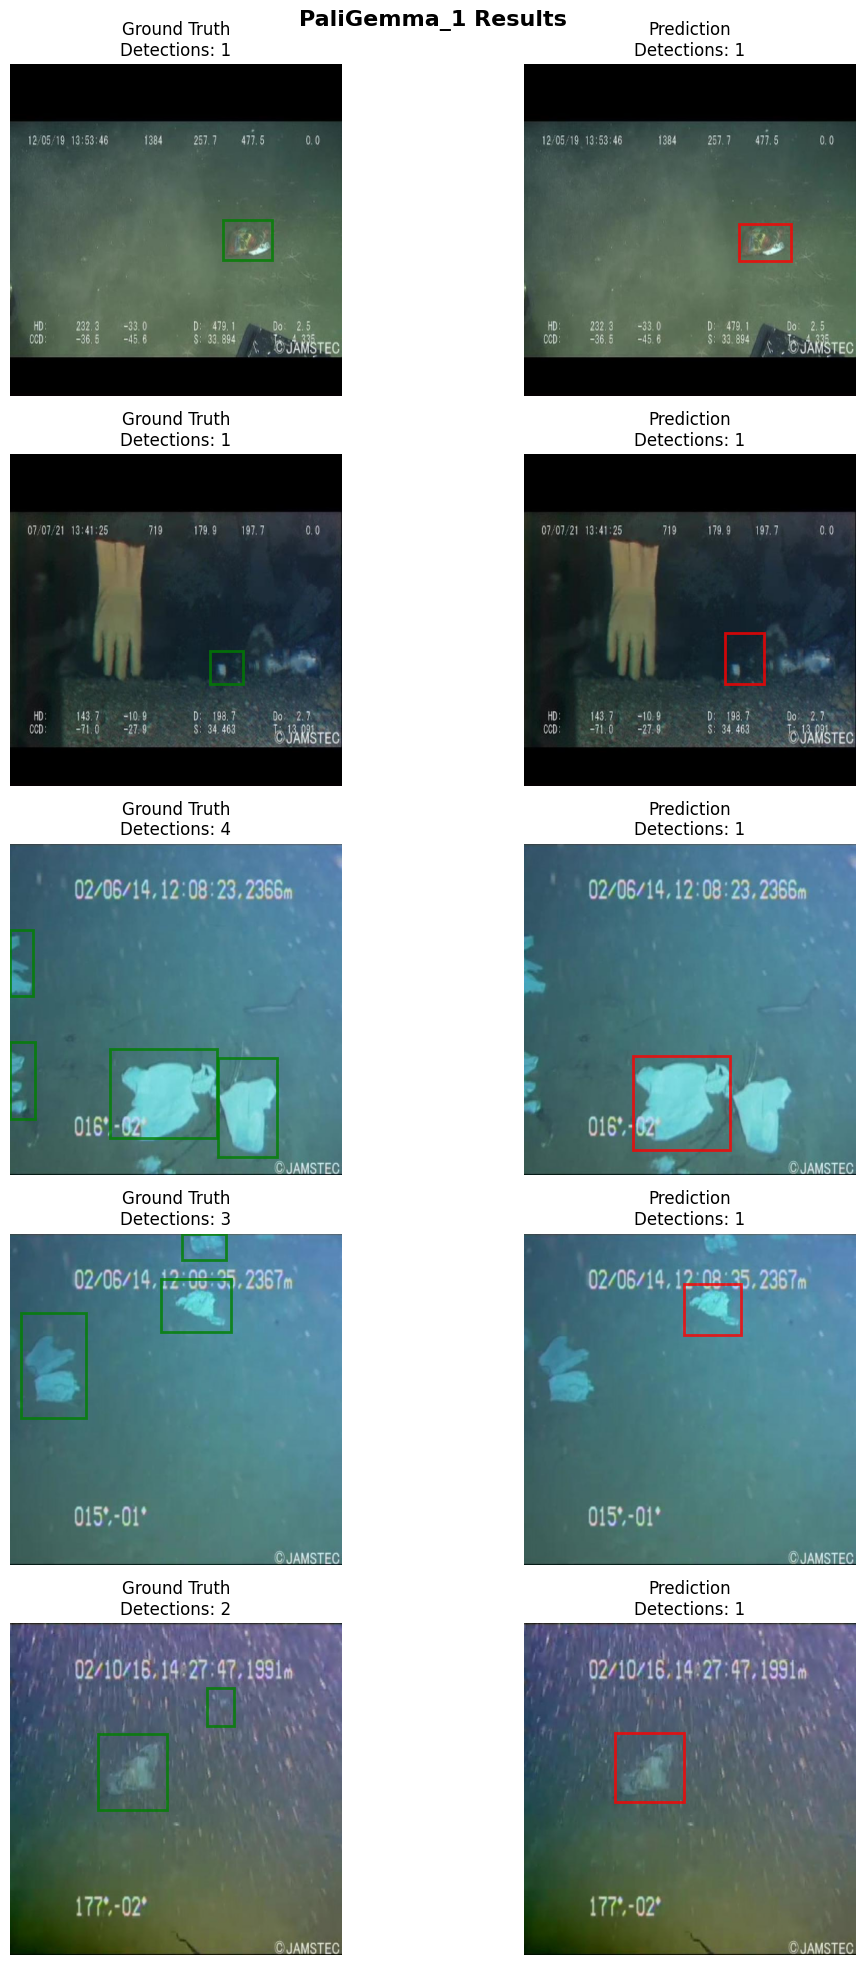


📊 INFERENCE SUMMARY

🎯 Model: PaliGemma_1
📂 Path: /content/drive/MyDrive/paligemma_1
🖼️  Images processed: 5

📈 Detection Statistics:
   Predicted: 5 (1.00 avg)
   Ground Truth: 11 (2.20 avg)

📋 Per-Image Results:
Image                         GT    Pred  Generated Text
--------------------------------------------------------------------------------
obj1107_frame0000098_jpg....  1     1     <loc0492><loc0662><loc0607><lo...
obj0707_frame0000024_jpg....  1     1     <loc0552><loc0620><loc0711><lo...
obj0332_frame0000027_jpg....  4     1     <loc0656><loc0337><loc0944><lo...
obj0332_frame0000063_jpg....  3     1     <loc0155><loc0492><loc0312><lo...
obj0343_frame0000018_jpg....  2     1     <loc0337><loc0281><loc0552><lo...

💾 Saving results...
   💾 Saved: single_model_results/PaliGemma_1_detailed_results.json

🎉 INFERENCE COMPLETED!
⏱️  Total time: 190.4 seconds
📁 Results saved in: single_model_results/


In [ ]:
# -*- coding: utf-8 -*-
"""
Single Model PaliGemma Inference Tool
Simplified version for testing one model at a time
"""

import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from tqdm import tqdm
import time
import gc
import warnings

# Core ML libraries
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
from peft import PeftModel
import supervision as sv

# Suppress deprecation warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting configuration
plt.style.use('default')

@dataclass
class SingleModelConfig:
    """Configuration for single model inference"""
    # Model path - CHANGE THIS TO YOUR MODEL
    model_path: str = "/content/drive/MyDrive/paligemma_1"  # Change to paligemma_2 if needed
    model_name: str = "PaliGemma_1"  # Friendly name

    # Dataset paths
    test_path: str = "Plastic-Detection-5/dataset/_annotations.test.jsonl"
    dataset_root: str = "Plastic-Detection-5/dataset"

    # Settings
    num_images: int = 10

    # Generation settings
    max_new_tokens: int = 256
    do_sample: bool = False
    temperature: float = 0.0
    num_beams: int = 1

    # Device settings
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    torch_dtype: torch.dtype = torch.bfloat16

    # Output settings
    output_dir: str = "single_model_results"

class SingleModelInference:
    """Simple single model inference"""

    def __init__(self, config: SingleModelConfig):
        self.config = config
        self.model = None
        self.processor = None
        self.test_data = []
        self.classes = ['plastic']
        self.results = []

        # Create output directory
        Path(self.config.output_dir).mkdir(exist_ok=True)

        print("="*60)
        print("🎯 SINGLE MODEL PALIGEMMA INFERENCE")
        print("="*60)
        print(f"📁 Model: {self.config.model_name}")
        print(f"📂 Path: {self.config.model_path}")
        print(f"🖼️  Images: {self.config.num_images}")
        print(f"💾 Device: {self.config.device}")
        if torch.cuda.is_available():
            total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
            print(f"🔥 GPU Memory: {total_memory:.1f}GB available")
        print("="*60)

    def cleanup_memory(self):
        """Clean up GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        gc.collect()

    def detect_base_model(self) -> str:
        """Auto-detect base model"""
        try:
            config_paths = [
                Path(self.config.model_path) / "training_config.json",
                Path(self.config.model_path) / "adapter_config.json",
                Path(self.config.model_path) / "config.json"
            ]

            for config_path in config_paths:
                if config_path.exists():
                    print(f"   📄 Found config: {config_path.name}")
                    with open(config_path, 'r') as f:
                        config = json.load(f)

                    # Look for base model
                    keys = ['model_id', 'base_model', '_name_or_path', 'model_name_or_path']
                    for key in keys:
                        if key in config and config[key]:
                            print(f"   🎯 Found base model: {config[key]}")
                            return config[key]
        except Exception as e:
            print(f"   ⚠️  Error reading config: {e}")

        # Fallback based on path
        if "paligemma2" in self.config.model_path.lower() or "paligemma_2" in self.config.model_path:
            fallback = "google/paligemma2-3b-pt-224"
        else:
            fallback = "google/paligemma-3b-pt-224"

        print(f"   🔄 Using fallback: {fallback}")
        return fallback

    def load_model(self):
        """Load the model"""
        print("\n🔄 Loading model...")

        # Check if path exists
        if not Path(self.config.model_path).exists():
            raise FileNotFoundError(f"❌ Model path not found: {self.config.model_path}")

        print(f"   ✅ Model path exists: {self.config.model_path}")

        try:
            # Detect base model
            base_model_id = self.detect_base_model()

            # Load processor
            print("   📝 Loading processor...")
            try:
                self.processor = PaliGemmaProcessor.from_pretrained(self.config.model_path)
                print("   ✅ Loaded processor from fine-tuned model")
            except:
                self.processor = PaliGemmaProcessor.from_pretrained(base_model_id)
                print("   ✅ Loaded processor from base model")

            # Load base model
            print(f"   🧠 Loading base model: {base_model_id}")
            base_model = PaliGemmaForConditionalGeneration.from_pretrained(
                base_model_id,
                torch_dtype=self.config.torch_dtype,
                device_map="auto",
                trust_remote_code=True
            )

            # Load LoRA weights
            print("   🔧 Loading LoRA weights...")
            self.model = PeftModel.from_pretrained(base_model, self.config.model_path)

            # Try to merge for faster inference
            try:
                print("   🔗 Merging LoRA weights...")
                self.model = self.model.merge_and_unload()
                print("   ✅ LoRA weights merged!")
            except Exception as e:
                print(f"   ⚠️  Could not merge: {e}")

            self.model.eval()

            # Show memory usage
            if torch.cuda.is_available():
                allocated = torch.cuda.memory_allocated() / 1e9
                print(f"   💾 GPU Memory: {allocated:.2f}GB")

            print("   ✅ Model loaded successfully!")

        except Exception as e:
            print(f"   ❌ Error loading model: {e}")
            raise

    def load_test_data(self):
        """Load test dataset"""
        print("\n📂 Loading test dataset...")

        if not Path(self.config.test_path).exists():
            raise FileNotFoundError(f"❌ Test file not found: {self.config.test_path}")

        # Load data
        with open(self.config.test_path, 'r', encoding='utf-8') as f:
            all_data = [json.loads(line) for line in f]

        # Select images
        self.test_data = all_data[:self.config.num_images]
        print(f"   📊 Selected {len(self.test_data)} images")

        # Pre-load images
        print("   🖼️  Loading images...")
        self.images = []
        self.image_info = []

        for item in tqdm(self.test_data, desc="Loading images"):
            img_path = Path(self.config.dataset_root) / item['image']
            if img_path.exists():
                image = Image.open(img_path).convert('RGB')

                # Resize if needed
                max_size = 1024
                if max(image.size) > max_size:
                    ratio = max_size / max(image.size)
                    new_size = (int(image.width * ratio), int(image.height * ratio))
                    image = image.resize(new_size, Image.Resampling.LANCZOS)

                self.images.append(image)
                self.image_info.append({
                    'path': item['image'],
                    'prompt': "<image>" + item['prefix'],
                    'gt_text': item['suffix'],
                    'size': image.size
                })

        print(f"   ✅ Loaded {len(self.images)} images")

    def generate_prediction(self, image: Image.Image, prompt: str) -> str:
        """Generate prediction for image"""
        try:
            # Prepare inputs
            inputs = self.processor(
                text=prompt,
                images=image,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=256
            ).to(self.config.device)

            # Convert to correct dtype
            if 'pixel_values' in inputs:
                inputs['pixel_values'] = inputs['pixel_values'].to(self.config.torch_dtype)

            prefix_length = inputs["input_ids"].shape[-1]

            # Generate
            with torch.inference_mode():
                generation = self.model.generate(
                    **inputs,
                    max_new_tokens=self.config.max_new_tokens,
                    do_sample=self.config.do_sample,
                    num_beams=self.config.num_beams,
                    temperature=self.config.temperature,
                    pad_token_id=self.processor.tokenizer.eos_token_id,
                    eos_token_id=self.processor.tokenizer.eos_token_id,
                    use_cache=True,
                    early_stopping=True
                )

            # Decode
            new_tokens = generation[0][prefix_length:]
            generated_text = self.processor.decode(new_tokens, skip_special_tokens=True)

            return generated_text.strip()

        except Exception as e:
            print(f"   ❌ Generation error: {e}")
            return f"Error: {str(e)}"

    def parse_detections(self, result_text: str, image_size: Tuple[int, int]) -> sv.Detections:
        """Parse detections using updated supervision API"""
        try:
            if "Error" in result_text:
                return sv.Detections.empty()

            # Updated to use from_vlm instead of from_lmm
            detections = sv.Detections.from_vlm(
                vlm='paligemma',  # Changed from 'lmm' to 'vlm'
                result=result_text,
                resolution_wh=image_size,
                classes=self.classes
            )

            if len(detections) > 0:
                detections.confidence = np.ones(len(detections))
                if not hasattr(detections, 'class_id') or detections.class_id is None:
                    detections.class_id = np.zeros(len(detections), dtype=int)

            return detections

        except Exception as e:
            print(f"   ⚠️  Parse error for '{result_text[:50]}...': {e}")
            return sv.Detections.empty()

    def run_inference(self):
        """Run inference on all images"""
        print("\n🎯 Running inference...")

        self.results = []

        for i, (image, info) in enumerate(tqdm(zip(self.images, self.image_info),
                                              desc="Processing images",
                                              total=len(self.images))):
            try:
                # Generate prediction
                pred_text = self.generate_prediction(image, info['prompt'])

                # Parse detections
                detections = self.parse_detections(pred_text, info['size'])
                gt_detections = self.parse_detections(info['gt_text'], info['size'])

                # Store result
                result = {
                    'image_path': info['path'],
                    'image': image,
                    'prompt': info['prompt'],
                    'generated_text': pred_text,
                    'ground_truth_text': info['gt_text'],
                    'predicted_detections': detections,
                    'ground_truth_detections': gt_detections,
                    'predicted_count': len(detections),
                    'ground_truth_count': len(gt_detections)
                }

                self.results.append(result)

                # Print progress
                if (i + 1) % 5 == 0 or i == 0:
                    print(f"   📊 Image {i+1}: Generated '{pred_text[:50]}...', Detections: {len(detections)}")

                # Clear cache
                if (i + 1) % 3 == 0:
                    torch.cuda.empty_cache()

            except Exception as e:
                print(f"   ❌ Error processing image {i}: {e}")
                # Add empty result
                self.results.append({
                    'image_path': info['path'],
                    'image': image,
                    'generated_text': f"Error: {str(e)}",
                    'predicted_detections': sv.Detections.empty(),
                    'ground_truth_detections': sv.Detections.empty(),
                    'predicted_count': 0,
                    'ground_truth_count': 0
                })

        total_predictions = sum(r['predicted_count'] for r in self.results)
        total_ground_truth = sum(r['ground_truth_count'] for r in self.results)

        print(f"\n   📊 Inference completed!")
        print(f"   🎯 Total predictions: {total_predictions}")
        print(f"   📋 Total ground truth: {total_ground_truth}")
        print(f"   📈 Average per image: {total_predictions/len(self.results):.2f}")

    def create_visualization(self):
        """Create visualization of results"""
        print("\n🎨 Creating visualization...")

        # Create grid
        cols = 2  # Ground Truth | Prediction
        rows = len(self.results)
        fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))

        if rows == 1:
            axes = axes.reshape(1, -1)

        for i, result in enumerate(self.results):
            # Ground Truth
            ax_gt = axes[i, 0] if rows > 1 else axes[0]
            ax_gt.imshow(result['image'])

            # Draw GT boxes in green
            for bbox in result['ground_truth_detections'].xyxy:
                x1, y1, x2, y2 = bbox
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                   linewidth=2, edgecolor='green',
                                   facecolor='none', alpha=0.8)
                ax_gt.add_patch(rect)

            ax_gt.set_title(f'Ground Truth\nDetections: {result["ground_truth_count"]}')
            ax_gt.axis('off')

            # Predictions
            ax_pred = axes[i, 1] if rows > 1 else axes[1]
            ax_pred.imshow(result['image'])

            # Draw prediction boxes in red
            for bbox in result['predicted_detections'].xyxy:
                x1, y1, x2, y2 = bbox
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                   linewidth=2, edgecolor='red',
                                   facecolor='none', alpha=0.8)
                ax_pred.add_patch(rect)

            ax_pred.set_title(f'Prediction\nDetections: {result["predicted_count"]}')
            ax_pred.axis('off')

        plt.suptitle(f'{self.config.model_name} Results', fontsize=16, fontweight='bold')
        plt.tight_layout()

        # Save
        vis_path = Path(self.config.output_dir) / f"{self.config.model_name}_results.png"
        plt.savefig(vis_path, dpi=300, bbox_inches='tight')
        print(f"   💾 Saved: {vis_path}")
        plt.show()

    def print_summary(self):
        """Print detailed summary"""
        print("\n" + "="*60)
        print("📊 INFERENCE SUMMARY")
        print("="*60)

        print(f"\n🎯 Model: {self.config.model_name}")
        print(f"📂 Path: {self.config.model_path}")
        print(f"🖼️  Images processed: {len(self.results)}")

        # Statistics
        total_pred = sum(r['predicted_count'] for r in self.results)
        total_gt = sum(r['ground_truth_count'] for r in self.results)

        print(f"\n📈 Detection Statistics:")
        print(f"   Predicted: {total_pred} ({total_pred/len(self.results):.2f} avg)")
        print(f"   Ground Truth: {total_gt} ({total_gt/len(self.results):.2f} avg)")

        # Per-image breakdown
        print(f"\n📋 Per-Image Results:")
        print("Image".ljust(30) + "GT".ljust(6) + "Pred".ljust(6) + "Generated Text")
        print("-" * 80)

        for result in self.results:
            img_name = Path(result['image_path']).name[:25]
            gt_count = result['ground_truth_count']
            pred_count = result['predicted_count']
            gen_text = result['generated_text'][:30]

            print(f"{img_name}...".ljust(30) +
                  f"{gt_count}".ljust(6) +
                  f"{pred_count}".ljust(6) +
                  f"{gen_text}...")

        print("="*60)

    def save_results(self):
        """Save detailed results"""
        print("\n💾 Saving results...")

        # Prepare data for JSON
        json_results = []
        for result in self.results:
            json_result = {
                'image_path': result['image_path'],
                'prompt': result['prompt'],
                'generated_text': result['generated_text'],
                'ground_truth_text': result['ground_truth_text'],
                'predicted_count': result['predicted_count'],
                'ground_truth_count': result['ground_truth_count'],
                'predicted_boxes': result['predicted_detections'].xyxy.tolist() if len(result['predicted_detections']) > 0 else [],
                'ground_truth_boxes': result['ground_truth_detections'].xyxy.tolist() if len(result['ground_truth_detections']) > 0 else []
            }
            json_results.append(json_result)

        # Save
        results_path = Path(self.config.output_dir) / f"{self.config.model_name}_detailed_results.json"
        with open(results_path, 'w') as f:
            json.dump(json_results, f, indent=2)

        print(f"   💾 Saved: {results_path}")

    def run_complete_inference(self):
        """Run complete inference pipeline"""
        start_time = time.time()

        try:
            # Load model and data
            self.load_model()
            self.load_test_data()

            # Run inference
            self.run_inference()

            # Create outputs
            self.create_visualization()
            self.print_summary()
            self.save_results()

            total_time = time.time() - start_time
            print(f"\n🎉 INFERENCE COMPLETED!")
            print(f"⏱️  Total time: {total_time:.1f} seconds")
            print(f"📁 Results saved in: {self.config.output_dir}/")

            return self.results

        except Exception as e:
            print(f"\n💥 Inference failed: {e}")
            import traceback
            traceback.print_exc()
            return None

# Main functions
def test_single_model(model_path: str,
                     model_name: str = None,
                     num_images: int = 10):
    """
    Test a single model

    Args:
        model_path: Path to your model (e.g., "/content/drive/MyDrive/paligemma_1")
        model_name: Friendly name (optional)
        num_images: Number of images to test
    """

    if model_name is None:
        model_name = Path(model_path).name

    config = SingleModelConfig(
        model_path=model_path,
        model_name=model_name,
        num_images=num_images
    )

    inferencer = SingleModelInference(config)
    return inferencer.run_complete_inference()

# Quick test functions
def test_paligemma_1(num_images: int = 10):
    """Test PaliGemma_1 model"""
    return test_single_model(
        model_path="/content/drive/MyDrive/paligemma_1",
        model_name="PaliGemma_1",
        num_images=num_images
    )

def test_paligemma_2(num_images: int = 10):
    """Test PaliGemma_2 model"""
    return test_single_model(
        model_path="/content/drive/MyDrive/paligemma_2",
        model_name="PaliGemma_2",
        num_images=num_images
    )

# Example usage
if __name__ == "__main__":
    print("🎯 Single Model PaliGemma Inference")
    print("="*50)
    print("Available functions:")
    print("• test_paligemma_1(10)  - Test PaliGemma_1 model")
    print("• test_paligemma_2(10)  - Test PaliGemma_2 model")
    print("• test_single_model(path, name, num) - Custom model")
    print("="*50)

    # Test PaliGemma_1 by default
    results = test_paligemma_1(num_images=5)

##Paligemma 2

🎯 Single Model PaliGemma Inference
Available functions:
• test_paligemma_1(10)  - Test PaliGemma_1 model
• test_paligemma_2(10)  - Test PaliGemma_2 model
• test_single_model(path, name, num) - Custom model
🎯 SINGLE MODEL PALIGEMMA INFERENCE
📁 Model: PaliGemma_2
📂 Path: /content/drive/MyDrive/paligemma_2
🖼️  Images: 3
💾 Device: cuda
🔥 GPU Memory: 23.8GB available

🔄 Loading model...
   ✅ Model path exists: /content/drive/MyDrive/paligemma_2
   📄 Found config: adapter_config.json
   🔄 Using fallback: google/paligemma2-3b-pt-224
   📝 Loading processor...


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


   ✅ Loaded processor from fine-tuned model
   🧠 Loading base model: google/paligemma2-3b-pt-224


config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

   🔧 Loading LoRA weights...
   🔗 Merging LoRA weights...
   ✅ LoRA weights merged!
   💾 GPU Memory: 6.09GB
   ✅ Model loaded successfully!

📂 Loading test dataset...
   📊 Selected 3 images
   🖼️  Loading images...


Loading images: 100%|██████████| 3/3 [00:00<00:00, 396.15it/s]


   ✅ Loaded 3 images

🎯 Running inference...


Processing images:  33%|███▎      | 1/3 [00:15<00:31, 15.74s/it]

   📊 Image 1: Generated '<loc0478><loc0650><loc0624><loc0821> plastic ; <lo...', Detections: 36


Processing images: 100%|██████████| 3/3 [00:46<00:00, 15.44s/it]



   📊 Inference completed!
   🎯 Total predictions: 90
   📋 Total ground truth: 6
   📈 Average per image: 30.00

🎨 Creating visualization...
   💾 Saved: single_model_results/PaliGemma_2_results.png


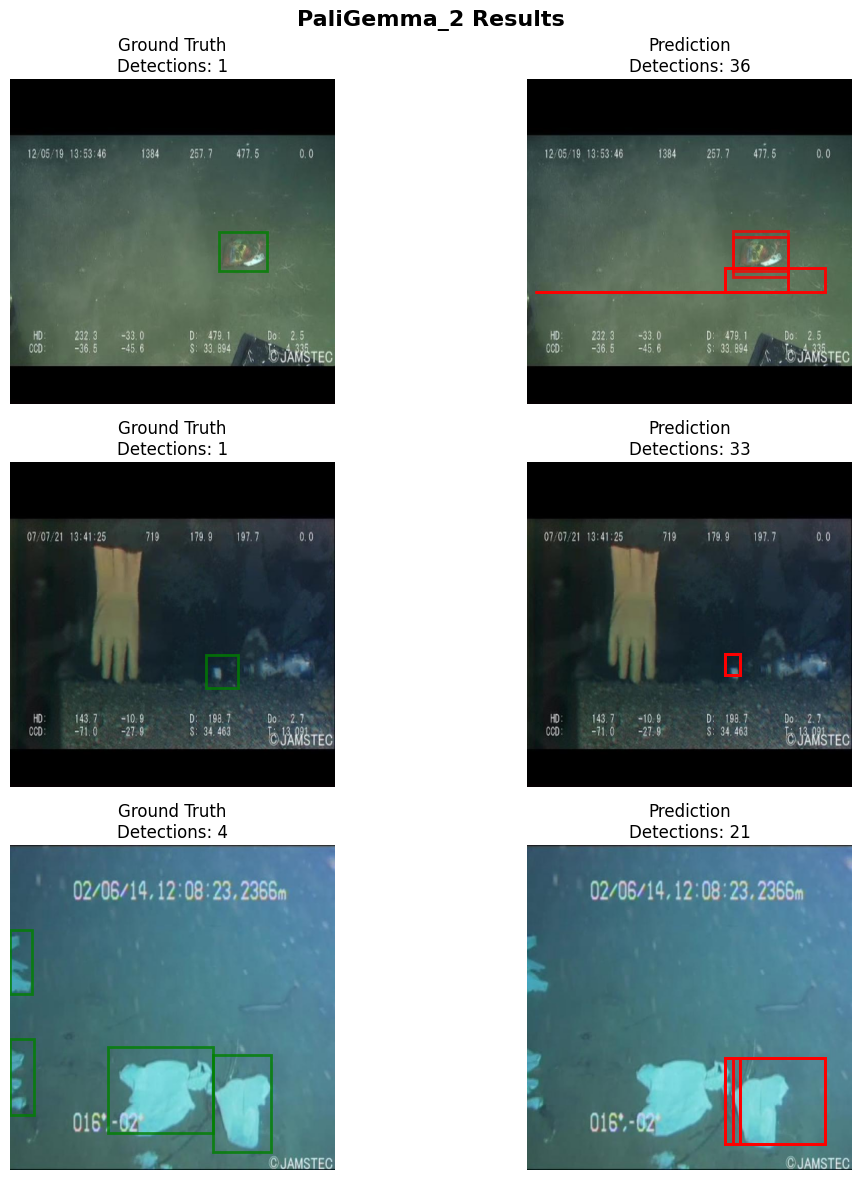


📊 INFERENCE SUMMARY

🎯 Model: PaliGemma_2
📂 Path: /content/drive/MyDrive/paligemma_2
🖼️  Images processed: 3

📈 Detection Statistics:
   Predicted: 90 (30.00 avg)
   Ground Truth: 6 (2.00 avg)

📋 Per-Image Results:
Image                         GT    Pred  Generated Text
--------------------------------------------------------------------------------
obj1107_frame0000098_jpg....  1     36    <loc0478><loc0650><loc0624><lo...
obj0707_frame0000024_jpg....  1     33    <loc0604><loc0624><loc0671><lo...
obj0332_frame0000027_jpg....  4     21    <loc0671><loc0624><loc0940><lo...

 Saving results...
    Saved: single_model_results/PaliGemma_2_detailed_results.json

 INFERENCE COMPLETED!
  Total time: 381.3 seconds
 Results saved in: single_model_results/


In [ ]:
# -*- coding: utf-8 -*-
"""
Single Model PaliGemma Inference Tool
Simplified version for testing one model at a time
"""

import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from tqdm import tqdm
import time
import gc
import warnings

# Core ML libraries
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
from peft import PeftModel
import supervision as sv

# Suppress deprecation warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting configuration
plt.style.use('default')

@dataclass
class SingleModelConfig:
    """Configuration for single model inference"""
    # Model path - CHANGE THIS TO YOUR MODEL
    model_path: str = "/content/drive/MyDrive/paligemma_1"  # Change to paligemma_2 if needed
    model_name: str = "PaliGemma_1"  # Friendly name

    # Dataset paths
    test_path: str = "Plastic-Detection-5/dataset/_annotations.test.jsonl"
    dataset_root: str = "Plastic-Detection-5/dataset"

    # Settings
    num_images: int = 10

    # Generation settings
    max_new_tokens: int = 256
    do_sample: bool = False
    temperature: float = 0.0
    num_beams: int = 1

    # Device settings
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    torch_dtype: torch.dtype = torch.bfloat16

    # Output settings
    output_dir: str = "single_model_results"

class SingleModelInference:
    """Simple single model inference"""

    def __init__(self, config: SingleModelConfig):
        self.config = config
        self.model = None
        self.processor = None
        self.test_data = []
        self.classes = ['plastic']
        self.results = []

        # Create output directory
        Path(self.config.output_dir).mkdir(exist_ok=True)

        print("="*60)
        print("🎯 SINGLE MODEL PALIGEMMA INFERENCE")
        print("="*60)
        print(f"📁 Model: {self.config.model_name}")
        print(f"📂 Path: {self.config.model_path}")
        print(f"🖼️  Images: {self.config.num_images}")
        print(f"💾 Device: {self.config.device}")
        if torch.cuda.is_available():
            total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
            print(f"🔥 GPU Memory: {total_memory:.1f}GB available")
        print("="*60)

    def cleanup_memory(self):
        """Clean up GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        gc.collect()

    def detect_base_model(self) -> str:
        """Auto-detect base model"""
        try:
            config_paths = [
                Path(self.config.model_path) / "training_config.json",
                Path(self.config.model_path) / "adapter_config.json",
                Path(self.config.model_path) / "config.json"
            ]

            for config_path in config_paths:
                if config_path.exists():
                    print(f"   📄 Found config: {config_path.name}")
                    with open(config_path, 'r') as f:
                        config = json.load(f)

                    # Look for base model
                    keys = ['model_id', 'base_model', '_name_or_path', 'model_name_or_path']
                    for key in keys:
                        if key in config and config[key]:
                            print(f"   🎯 Found base model: {config[key]}")
                            return config[key]
        except Exception as e:
            print(f"   ⚠️  Error reading config: {e}")

        # Fallback based on path
        if "paligemma2" in self.config.model_path.lower() or "paligemma_2" in self.config.model_path:
            fallback = "google/paligemma2-3b-pt-224"
        else:
            fallback = "google/paligemma-3b-pt-224"

        print(f"   🔄 Using fallback: {fallback}")
        return fallback

    def load_model(self):
        """Load the model"""
        print("\n🔄 Loading model...")

        # Check if path exists
        if not Path(self.config.model_path).exists():
            raise FileNotFoundError(f"❌ Model path not found: {self.config.model_path}")

        print(f"   ✅ Model path exists: {self.config.model_path}")

        try:
            # Detect base model
            base_model_id = self.detect_base_model()

            # Load processor
            print("   📝 Loading processor...")
            try:
                self.processor = PaliGemmaProcessor.from_pretrained(self.config.model_path)
                print("   ✅ Loaded processor from fine-tuned model")
            except:
                self.processor = PaliGemmaProcessor.from_pretrained(base_model_id)
                print("   ✅ Loaded processor from base model")

            # Load base model
            print(f"   🧠 Loading base model: {base_model_id}")
            base_model = PaliGemmaForConditionalGeneration.from_pretrained(
                base_model_id,
                torch_dtype=self.config.torch_dtype,
                device_map="auto",
                trust_remote_code=True
            )

            # Load LoRA weights
            print("   🔧 Loading LoRA weights...")
            self.model = PeftModel.from_pretrained(base_model, self.config.model_path)

            # Try to merge for faster inference
            try:
                print("   🔗 Merging LoRA weights...")
                self.model = self.model.merge_and_unload()
                print("   ✅ LoRA weights merged!")
            except Exception as e:
                print(f"   ⚠️  Could not merge: {e}")

            self.model.eval()

            # Show memory usage
            if torch.cuda.is_available():
                allocated = torch.cuda.memory_allocated() / 1e9
                print(f"   💾 GPU Memory: {allocated:.2f}GB")

            print("   ✅ Model loaded successfully!")

        except Exception as e:
            print(f"   ❌ Error loading model: {e}")
            raise

    def load_test_data(self):
        """Load test dataset"""
        print("\n📂 Loading test dataset...")

        if not Path(self.config.test_path).exists():
            raise FileNotFoundError(f"❌ Test file not found: {self.config.test_path}")

        # Load data
        with open(self.config.test_path, 'r', encoding='utf-8') as f:
            all_data = [json.loads(line) for line in f]

        # Select images
        self.test_data = all_data[:self.config.num_images]
        print(f"   📊 Selected {len(self.test_data)} images")

        # Pre-load images
        print("   🖼️  Loading images...")
        self.images = []
        self.image_info = []

        for item in tqdm(self.test_data, desc="Loading images"):
            img_path = Path(self.config.dataset_root) / item['image']
            if img_path.exists():
                image = Image.open(img_path).convert('RGB')

                # Resize if needed
                max_size = 1024
                if max(image.size) > max_size:
                    ratio = max_size / max(image.size)
                    new_size = (int(image.width * ratio), int(image.height * ratio))
                    image = image.resize(new_size, Image.Resampling.LANCZOS)

                self.images.append(image)
                self.image_info.append({
                    'path': item['image'],
                    'prompt': "<image>" + item['prefix'],
                    'gt_text': item['suffix'],
                    'size': image.size
                })

        print(f"   ✅ Loaded {len(self.images)} images")

    def generate_prediction(self, image: Image.Image, prompt: str) -> str:
        """Generate prediction for image"""
        try:
            # Prepare inputs
            inputs = self.processor(
                text=prompt,
                images=image,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=256
            ).to(self.config.device)

            # Convert to correct dtype
            if 'pixel_values' in inputs:
                inputs['pixel_values'] = inputs['pixel_values'].to(self.config.torch_dtype)

            prefix_length = inputs["input_ids"].shape[-1]

            # Generate
            with torch.inference_mode():
                generation = self.model.generate(
                    **inputs,
                    max_new_tokens=self.config.max_new_tokens,
                    do_sample=self.config.do_sample,
                    num_beams=self.config.num_beams,
                    temperature=self.config.temperature,
                    pad_token_id=self.processor.tokenizer.eos_token_id,
                    eos_token_id=self.processor.tokenizer.eos_token_id,
                    use_cache=True,
                    early_stopping=True
                )

            # Decode
            new_tokens = generation[0][prefix_length:]
            generated_text = self.processor.decode(new_tokens, skip_special_tokens=True)

            return generated_text.strip()

        except Exception as e:
            print(f"   ❌ Generation error: {e}")
            return f"Error: {str(e)}"

    def parse_detections(self, result_text: str, image_size: Tuple[int, int]) -> sv.Detections:
        """Parse detections using updated supervision API"""
        try:
            if "Error" in result_text:
                return sv.Detections.empty()

            # Updated to use from_vlm instead of from_lmm
            detections = sv.Detections.from_vlm(
                vlm='paligemma',  # Changed from 'lmm' to 'vlm'
                result=result_text,
                resolution_wh=image_size,
                classes=self.classes
            )

            if len(detections) > 0:
                detections.confidence = np.ones(len(detections))
                if not hasattr(detections, 'class_id') or detections.class_id is None:
                    detections.class_id = np.zeros(len(detections), dtype=int)

            return detections

        except Exception as e:
            print(f"   ⚠️  Parse error for '{result_text[:50]}...': {e}")
            return sv.Detections.empty()

    def run_inference(self):
        """Run inference on all images"""
        print("\n🎯 Running inference...")

        self.results = []

        for i, (image, info) in enumerate(tqdm(zip(self.images, self.image_info),
                                              desc="Processing images",
                                              total=len(self.images))):
            try:
                # Generate prediction
                pred_text = self.generate_prediction(image, info['prompt'])

                # Parse detections
                detections = self.parse_detections(pred_text, info['size'])
                gt_detections = self.parse_detections(info['gt_text'], info['size'])

                # Store result
                result = {
                    'image_path': info['path'],
                    'image': image,
                    'prompt': info['prompt'],
                    'generated_text': pred_text,
                    'ground_truth_text': info['gt_text'],
                    'predicted_detections': detections,
                    'ground_truth_detections': gt_detections,
                    'predicted_count': len(detections),
                    'ground_truth_count': len(gt_detections)
                }

                self.results.append(result)

                # Print progress
                if (i + 1) % 5 == 0 or i == 0:
                    print(f"   📊 Image {i+1}: Generated '{pred_text[:50]}...', Detections: {len(detections)}")

                # Clear cache
                if (i + 1) % 3 == 0:
                    torch.cuda.empty_cache()

            except Exception as e:
                print(f"   ❌ Error processing image {i}: {e}")
                # Add empty result
                self.results.append({
                    'image_path': info['path'],
                    'image': image,
                    'generated_text': f"Error: {str(e)}",
                    'predicted_detections': sv.Detections.empty(),
                    'ground_truth_detections': sv.Detections.empty(),
                    'predicted_count': 0,
                    'ground_truth_count': 0
                })

        total_predictions = sum(r['predicted_count'] for r in self.results)
        total_ground_truth = sum(r['ground_truth_count'] for r in self.results)

        print(f"\n   📊 Inference completed!")
        print(f"   🎯 Total predictions: {total_predictions}")
        print(f"   📋 Total ground truth: {total_ground_truth}")
        print(f"   📈 Average per image: {total_predictions/len(self.results):.2f}")

    def create_visualization(self):
        """Create visualization of results"""
        print("\n🎨 Creating visualization...")

        # Create grid
        cols = 2  # Ground Truth | Prediction
        rows = len(self.results)
        fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))

        if rows == 1:
            axes = axes.reshape(1, -1)

        for i, result in enumerate(self.results):
            # Ground Truth
            ax_gt = axes[i, 0] if rows > 1 else axes[0]
            ax_gt.imshow(result['image'])

            # Draw GT boxes in green
            for bbox in result['ground_truth_detections'].xyxy:
                x1, y1, x2, y2 = bbox
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                   linewidth=2, edgecolor='green',
                                   facecolor='none', alpha=0.8)
                ax_gt.add_patch(rect)

            ax_gt.set_title(f'Ground Truth\nDetections: {result["ground_truth_count"]}')
            ax_gt.axis('off')

            # Predictions
            ax_pred = axes[i, 1] if rows > 1 else axes[1]
            ax_pred.imshow(result['image'])

            # Draw prediction boxes in red
            for bbox in result['predicted_detections'].xyxy:
                x1, y1, x2, y2 = bbox
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                   linewidth=2, edgecolor='red',
                                   facecolor='none', alpha=0.8)
                ax_pred.add_patch(rect)

            ax_pred.set_title(f'Prediction\nDetections: {result["predicted_count"]}')
            ax_pred.axis('off')

        plt.suptitle(f'{self.config.model_name} Results', fontsize=16, fontweight='bold')
        plt.tight_layout()

        # Save
        vis_path = Path(self.config.output_dir) / f"{self.config.model_name}_results.png"
        plt.savefig(vis_path, dpi=300, bbox_inches='tight')
        print(f"   💾 Saved: {vis_path}")
        plt.show()

    def print_summary(self):
        """Print detailed summary"""
        print("\n" + "="*60)
        print("📊 INFERENCE SUMMARY")
        print("="*60)

        print(f"\n🎯 Model: {self.config.model_name}")
        print(f"📂 Path: {self.config.model_path}")
        print(f"🖼️  Images processed: {len(self.results)}")

        # Statistics
        total_pred = sum(r['predicted_count'] for r in self.results)
        total_gt = sum(r['ground_truth_count'] for r in self.results)

        print(f"\n📈 Detection Statistics:")
        print(f"   Predicted: {total_pred} ({total_pred/len(self.results):.2f} avg)")
        print(f"   Ground Truth: {total_gt} ({total_gt/len(self.results):.2f} avg)")

        # Per-image breakdown
        print(f"\n📋 Per-Image Results:")
        print("Image".ljust(30) + "GT".ljust(6) + "Pred".ljust(6) + "Generated Text")
        print("-" * 80)

        for result in self.results:
            img_name = Path(result['image_path']).name[:25]
            gt_count = result['ground_truth_count']
            pred_count = result['predicted_count']
            gen_text = result['generated_text'][:30]

            print(f"{img_name}...".ljust(30) +
                  f"{gt_count}".ljust(6) +
                  f"{pred_count}".ljust(6) +
                  f"{gen_text}...")

        print("="*60)

    def save_results(self):
        """Save detailed results"""
        print("\n💾 Saving results...")

        # Prepare data for JSON
        json_results = []
        for result in self.results:
            json_result = {
                'image_path': result['image_path'],
                'prompt': result['prompt'],
                'generated_text': result['generated_text'],
                'ground_truth_text': result['ground_truth_text'],
                'predicted_count': result['predicted_count'],
                'ground_truth_count': result['ground_truth_count'],
                'predicted_boxes': result['predicted_detections'].xyxy.tolist() if len(result['predicted_detections']) > 0 else [],
                'ground_truth_boxes': result['ground_truth_detections'].xyxy.tolist() if len(result['ground_truth_detections']) > 0 else []
            }
            json_results.append(json_result)

        # Save
        results_path = Path(self.config.output_dir) / f"{self.config.model_name}_detailed_results.json"
        with open(results_path, 'w') as f:
            json.dump(json_results, f, indent=2)

        print(f"   💾 Saved: {results_path}")

    def run_complete_inference(self):
        """Run complete inference pipeline"""
        start_time = time.time()

        try:
            # Load model and data
            self.load_model()
            self.load_test_data()

            # Run inference
            self.run_inference()

            # Create outputs
            self.create_visualization()
            self.print_summary()
            self.save_results()

            total_time = time.time() - start_time
            print(f"\n🎉 INFERENCE COMPLETED!")
            print(f"⏱️  Total time: {total_time:.1f} seconds")
            print(f"📁 Results saved in: {self.config.output_dir}/")

            return self.results

        except Exception as e:
            print(f"\n💥 Inference failed: {e}")
            import traceback
            traceback.print_exc()
            return None

# Main functions
def test_single_model(model_path: str,
                     model_name: str = None,
                     num_images: int = 10):
    """
    Test a single model

    Args:
        model_path: Path to your model (e.g., "/content/drive/MyDrive/paligemma_1")
        model_name: Friendly name (optional)
        num_images: Number of images to test
    """

    if model_name is None:
        model_name = Path(model_path).name

    config = SingleModelConfig(
        model_path=model_path,
        model_name=model_name,
        num_images=num_images
    )

    inferencer = SingleModelInference(config)
    return inferencer.run_complete_inference()

# Quick test functions
def test_paligemma_1(num_images: int = 10):
    """Test PaliGemma_1 model"""
    return test_single_model(
        model_path="/content/drive/MyDrive/paligemma_1",
        model_name="PaliGemma_1",
        num_images=num_images
    )

def test_paligemma_2(num_images: int = 10):
    """Test PaliGemma_2 model"""
    return test_single_model(
        model_path="/content/drive/MyDrive/paligemma_2",
        model_name="PaliGemma_2",
        num_images=num_images
    )

# Example usage
if __name__ == "__main__":
    print("🎯 Single Model PaliGemma Inference")
    print("="*50)
    print("Available functions:")
    print("• test_paligemma_1(10)  - Test PaliGemma_1 model")
    print("• test_paligemma_2(10)  - Test PaliGemma_2 model")
    print("• test_single_model(path, name, num) - Custom model")
    print("="*50)

    # Test PaliGemma_2
    results = test_paligemma_2(num_images=3)